- https://scikit-learn.org/stable/modules/outlier_detection.html#
- https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders

In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

# Dataset Preparation

In [4]:
data = pd.read_csv('creditcard.csv')
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [6]:
# Consider only 1000 rows of non fraud cases 1000:492
Consider only 1000 rows of non fraud cases
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

C:\Users\SisLab\AppData\Local\Temp\ipykernel_13600\3091554375.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


# Visualize Fraud and NonFraud Transactions

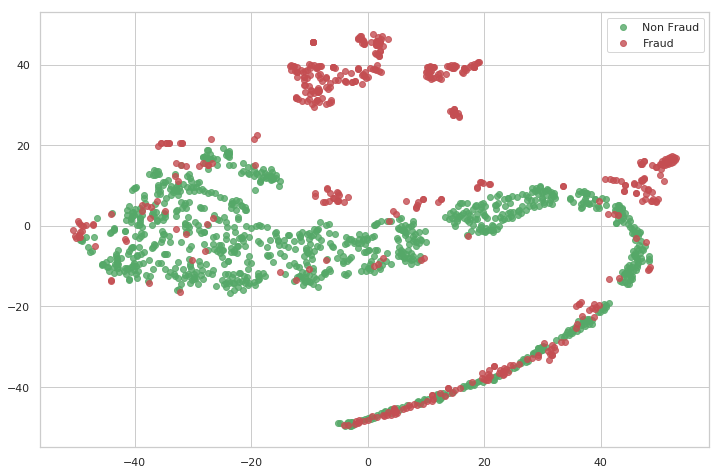

# AutoEncoders to the rescue
non-fruad cases에만 적용

In [8]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [9]:
# Create the model architecture by compiling input layer and output layers.
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [10]:
# min max scaling
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [11]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 31ms/step - loss: 0.1882 - val_loss: 0.1875
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1879 - val_loss: 0.1871
Epoch 3/10
7/7 [==============================] - 0s 9ms/step - loss: 0.1875 - val_loss: 0.1868
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 0.1871 - val_loss: 0.1864
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.1868 - val_loss: 0.1860
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1864 - val_loss: 0.1857
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1860 - val_loss: 0.1853
Epoch 8/10
7/7 [==============================] - 0s 6ms/step - loss: 0.1857 - val_loss: 0.1849
Epoch 9/10
7/7 [==============================] - 0s 6ms/step - loss: 0.1853 - val_loss: 0.1846
Epoch 10/10
7/7 [==============================] - 0s 6ms/step - loss: 0.1849 - val_loss: 0.1842


In [12]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [13]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 1ms/step


# Visualize the latent representations : Fraud Vs Non Fraud

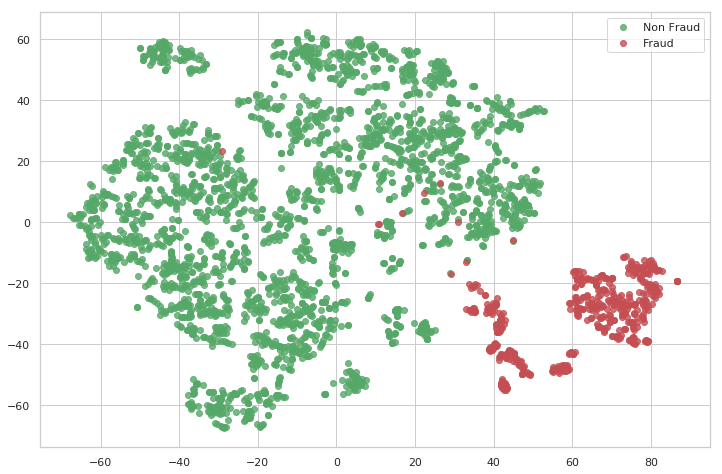

In [16]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [17]:
# Simple Linear Classifier
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.89      0.94       131

    accuracy                           0.98       873
   macro avg       0.99      0.94      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score:  0.9828178694158075


# Applying to a different dataset : PaySim

In [39]:
ps_data = pd.read_csv('ps.csv')
ps_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [40]:
ps_data["type"] = ps_data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
print(ps_data.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [41]:
train = ps_data[['type','amount','oldbalanceOrg','newbalanceOrig']]
test = ps_data(['isFraud'], axis=1)

In [44]:
non_fraud = train[train['isFraud'] == 0].sample(1000)
fraud = train[train['isFraud'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = train.drop(["Survived"], axis=1)
y = train["Survived"]
y = y.values

KeyError: 'isFraud'

In [35]:
## define the model
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [36]:
# Train the model
scaler = preprocessing.MinMaxScaler()
scaler.fit(X.values)
X_scale = scaler.transform(X.values)
test_x_scale = scaler.transform(test.values)

x_perished, x_survived = X_scale[y == 0], X_scale[y == 1]
autoencoder.fit(x_perished, x_perished, epochs = 20, shuffle = True, validation_split = 0.25)

ValueError: could not convert string to float: 'PAYMENT'